# Week 10 (Wednesday), AST 8581 / PHYS 8581 / CSCI 8581 / STAT 8581: Big Data in Astrophysics

### Michael Coughlin <cough052@umn.edu>, Jie Ding <dingj@umn.edu>

With contributions totally ripped off from Theophile Jegou Du Laz (Caltech) and Nabeel Rehemtulla (Northwestern)


# Where are we headed?

Foundations of Data and Probability -> Statistical frameworks (Frequentist vs Bayesian) -> Estimating underlying distributions -> Analysis of Time series (periodicity) -> Analysis of Time series (variability) -> Analysis of Time series (stochastic processes) -> Gaussian Processes -> Decision Trees / Regression -> Dimensionality Reduction  -> Principle Component Analysis -> Clustering / Density Estimation / Anomaly Detection -> Supervised Learning -> <b> Deep Learning </b> -> Introduction to Databases - SQL -> Introduction to Databases - NoSQL -> Introduction to Multiprocessing -> Introduction to GPUs -> Unit Testing

# In-class Exercise: Automated spectroscopic follow-up for the Zwicky Transient Facility (ZTF) using deep learning

## Efficient automated detection of flux-transient, reoccurring flux-variable, and moving objects is increasingly important for large-scale astronomical surveys.

* Events observed by ZTF may have been triggered from a flux-transient, a reoccurring flux-variable, or a moving object. The metadata and contextual information including the cutouts are put into "alert packets" that are distributed via the ZTF Alert Distribution System (ZADS). On a typical night, the number of detected events ranges from $10^5 - 10^6$.

<img src='img/fig-ztf_alerts.png' width=500>

Overview:

We'll have a look at how the alert scanning process can be automatized (or at least facilitated) by teaching neural networks how to look at the cutouts and metadata from the alert packets just like humans would. We'll talk about the model's architecture, how to train it, evaluate it, and how to fine-tune it with the help of wandb.ai.


In [1]:
# but of course, let's start with the imports
import numpy as np
import pandas as pd
import tensorflow as tf
import wandb
from ast import literal_eval

from tensorflow import keras
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Concatenate, SeparableConv2D, GlobalAveragePooling2D, BatchNormalization, Activation
import scipy

2024-03-23 17:18:41.491478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Downloading the dataset (run only once):

In [2]:
# https://docs.google.com/uc?export=download&id=16ufsYYbpJ0ZWw2ZIibPfQQ81k7OBNl9Z
!unzip data.zip -d data

unzip:  cannot find or open data.zip, data.zip.zip or data.zip.ZIP.


----

## Introduction

### Quick reminder: Convolutional Neural Network (CNN)

"In deep learning, a convolutional neural network (CNN) is a class of artificial neural network most commonly applied to analyze visual imagery.[1] CNNs use a mathematical operation called convolution in place of general matrix multiplication in at least one of their layers.[2] They are specifically designed to process pixel data and are used in image recognition and processing."
*https://en.wikipedia.org/wiki/Convolutional_neural_network*

<img src="https://miro.medium.com/v2/resize:fit:1162/format:webp/1*tvwYybdIwvoOs0DuUEJJTg.png" alt="Drawing" style="width: 800px;"/>
<p style="font-size: 10px;">Source: https://medium.com/techiepedia/binary-image-classifier-cnn-using-tensorflow-a3f5d6746697</p>


A basic CNN is composed of several layers:
- Convolutional layers: they apply a convolution operation to the input, passing the result to the next layer.
- Pooling layers: they downsample the input along the spatial dimensions (width, height), reducing the number of parameters and computation in the network.
- Fully connected layers: they compute the class scores, resulting in a vector of size equal to the number of classes. If the classification we expect is binary (simply True if >0.5, otherwise False), the last layer is a single neuron with a sigmoid activation function.

The input can be either a single image, composed of one or more channels (e.g. RGB), or a batch of images of the same size. When it comes to the cutouts found in the ZTF alert packets, they are a set of 3 images (science, template, difference) of size 63x63 pixels, each with 1 channel (grayscale). Meaning the imput is of size (63, 63, 3).

<img src="./img/alert_cutouts.png" alt="Drawing" style="width: 800px;"/>
<p style="font-size: 10px;">Screenshot (from fritz.science) of the cutouts from the latest alert for ZTF23aaqqfac</p>

### What about metadata?

Often, the data available isn't just one or more image, but also metadata that was computed which can be used to improve the classification. For example, the metadata can be the position of the object, the time of the observation, the magnitude of the object, etc. The metadata can be used in two ways:
- As an additional input to the CNN, concatenated to the image.
- As an additional input to the CNN, concatenated to the output of the last convolutional layer.

Later in this notebook, you'll see that the process of "merging" the CNN model and the metadata (which is a classic neural network) model into one is extremely simple.

The metadata goes through its own set of fully connected layers, and the output is concatenated to the output of the last convolutional layer after it has been flattened. The resulting vector is then fed to the fully connected layers that later compute the class scores. The BTS model aims to predict one thing: the probability that the object is a bright transient, of interest for the Bright Transient Survey (BTS) group.

<img src="http://neuralnetworksanddeeplearning.com/images/tikz11.png" alt="Drawing" style="width: 800px; background-color: white;"/>
<p style="font-size: 10px;">Basic neural network with 2 hidden layers, with one neuron as an ouput to perform binary classification. Just like the one our alert metadata will go through. Source: http://neuralnetworksanddeeplearning.com/chap1.html</p>

### But why do we need AI for any of this?

<img src="https://substackcdn.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa327668d-b172-44e7-a2b0-4671c235ce79_682x500.jpeg" alt="Drawing" style="width: 600px;"/>

"The Bright Transient Survey (BTS) relies on visual inspection (“scanning”) to select sources
for accomplishing its mission of spectroscopically classifying all bright extragalactic transients
found by the Zwicky Transient Facility (ZTF).
We present BTSbot, a multi-input convolutional
neural network, which provides a bright transient
score to individual ZTF detections using their image data and 14 extracted features. BTSbot eliminates the need for scanning by automatically identifying and requesting follow-up observations of
new bright (m < 18.5 mag) transient candidates.
In validation, BTSbot outperforms BTS scanners in terms of completeness (99% vs. 95%) and
identification speed (on average, 7.4 h quicker)."

Source: Nabeel Rehemtulla, Northwestern University

To summarize: Instead of relaying on people to look at thousands of alerts every day to find which one are worth getting a spectra for, we train a model to do it for us. Just like a person scanning, the model can look at both images and metadata, except more consistently and orders of magnitude faster.

----

# Start Understanding the Data
Initially, the goal is to familiarize ourselves with the data.

In [3]:
pd.set_option('display.max_columns', None)

config = {'train_data_version': "ZTFSS"}

cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
cand.drop('label', axis=1)

,objectId,jd,fid,diffmaglim,candid,isdiffpos,field,ra,dec,magpsf,sigmapsf,magap,sigmagap,distnr,magnr,sharpnr,sky,magdiff,fwhm,classtar,mindtoedge,seeratio,nneg,nbad,magapbig,sigmagapbig,sgscore1,distpsnr1,ndethist,ncovhist,scorr,sgscore2,distpsnr2,sgscore3,distpsnr3,dsnrms,ssnrms,magzpsci,magzpsciunc,magzpscirms,neargaia,neargaiabright,maggaia,maggaiabright,exptime,drb,acai_h,acai_v,acai_o,acai_n,acai_b,objectidps1,rapsnr1,decpsnr1,classpsnr1,photozpsnr1,peakmag,jdstarthist,sgmag1,srmag1,simag1,szmag1,sgmag2,srmag2,simag2,szmag2,sgmag3,srmag3,simag3,szmag3,nmtchps,peakmag_so_far,age,sigmagnr,source_set,N,split,is_SN,near_threshold,is_rise,programid
0,ZTF19acjurot,2.458813e+06,1,19.575621,1058126442015015014,True,339,320.853375,-17.720127,18.519318,0.107349,18.484200,0.1133,0.051656,21.006001,0.042,-0.336216,-0.035118,4.37,0.954,542.868286,0.726510,2,0,18.561001,0.1555,0.009167,0.008522,10,133,19.088232,0.500000,0.558093,0.000000,7.119209,8.923703,21.079872,25.952318,0.000013,0.044490,20.146357,-999.000000,19.356363,-999.000000,30.0,0.999998,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,86733208532106386,320.853374,-17.720097,GALAXY,0.223341,17.826855,2.458786e+06,21.360800,21.077299,-999.000000,20.695000,21.312500,21.100700,20.976101,20.483601,21.799299,20.967600,20.433100,19.911600,9,17.826855,26.945312,0.101,trues,1,train,True,False,False,1
1,ZTF22aafjjqf,2.459696e+06,2,19.677853,1941204741815015004,True,613,101.667662,24.738616,19.334347,0.149378,19.283199,0.2868,2.232527,17.828001,0.526,0.663877,-0.051146,2.92,0.946,512.424316,0.836199,4,0,19.232901,0.3477,0.063750,2.461800,4,1282,7.565492,0.074896,3.125654,0.500000,5.643149,5.236142,10.581785,26.113346,0.000002,0.024998,10.268768,80.509659,20.239159,12.949177,30.0,0.999643,0.996466,0.000034,0.000295,0.007172,0.000332,137681016683466749,101.668395,24.738473,GALAXY,0.069504,18.947762,2.459680e+06,18.764500,18.483400,18.018499,18.052900,18.823700,-999.000000,-999.000000,-999.000000,-999.000000,19.416100,19.573900,-999.000000,14,18.947762,16.049803,0.069,dims,1,train,True,False,False,1
2,ZTF21abwdwtd,2.459470e+06,2,20.612297,1715464063615015000,True,456,69.795197,5.890555,19.972393,0.139238,20.060101,0.2475,2.118342,19.500000,0.482,0.041897,0.087707,1.93,0.972,1316.310547,1.248944,5,0,20.395201,0.4291,0.002708,2.166561,14,569,11.499949,0.500000,2.459587,0.001250,19.563740,11.358811,16.665583,26.284393,0.000003,0.036511,38.642532,-999.000000,21.025726,-999.000000,30.0,0.999976,0.994752,0.000026,0.000139,0.003948,0.000014,115060697951018637,-999.000000,-999.000000,-999.0,-999.000000,19.564911,2.459445e+06,20.309200,20.045601,19.781799,19.614300,20.290899,20.296400,19.658400,19.980600,21.263100,21.127399,20.813400,20.762699,4,19.564911,25.019676,0.091,dims,1,train,True,False,False,1
3,ZTF20aafxahn,2.458874e+06,1,20.838610,1119344622715015015,True,785,135.322332,53.610332,18.951622,0.080455,18.882799,0.0650,3.017254,22.972000,-0.234,0.006160,-0.068822,2.56,0.982,365.377289,1.017346,3,0,18.874100,0.0814,-999.000000,-999.000000,23,538,35.371441,-999.000000,-999.000000,-999.000000,-999.000000,28.408604,52.260601,26.297623,0.000024,0.060046,63.542225,-999.000000,16.672007,-999.000000,30.0,1.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999,-999.000000,-999.000000,-999.0,-999.000000,18.857655,2.458863e+06,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,-999.000000,0,18.934233,11.019583,0.321,dims,1,train,True,False,True,1
4,ZTF21abuegvc,2.459463e+06,2,20.803921,1708406203615015002,True,653,41.303101,35.047421,19.653652,0.123777,20.026199,0.2172,0.602962,18.764000,0.385,0.633275,0.372548,2.25,0.977,426.286102,1.015112,7,0,20.156900,0.3093,0.001250,0.544231,11,960,14.440203,0.989583,14.400186,0.985042,17.610506,11.407976,22.890976,26.308653,0.000002,0.034840,14.398755,-999.000000,20.167376,-999.000000,30.0,0.999999,0.991072,0.000237,0.000249,0.009643,0.000033,15005041

## BTS model

As mentioned earlier, the model is composed of two parts: the CNN and the metadata part, merged to yield one output. Here is what it looks like:

### Architecture:

CNN model:
- 2 blocks of 2 convolutional layers, each followed by a pooling layer, and a dropout layer.
- a flatten layer.

Metadata model:
- 2 fully connected layers.

Merged model:
- the output of the flatten layer of the CNN model is concatenated to the output of the metadata model.
- Followed by one fully connected layer, a dropout layer, and the output layer (a single neuron with a sigmoid activation function).


In [4]:
# we define some basic constants.
config = {
    'image_size': (63,63,3),
    'metadata_size': (14,),
    'dropout_1': 0.5,
    'dropout_2': 0.3,
    'dropout_3': 0.2,
}

In [5]:
from keras import models
from keras import layers
from keras import Input
from keras import Model
from keras import regularizers
from keras import callbacks

# first we prepare the input layers
triplet_input = Input(shape=config["image_size"], name='triplet')
meta_input = Input(shape=config["metadata_size"], name='metadata')

CNN part of the model:

#### FIRST EXERCISE: Re-design the model based on these specifications:
1. Conv branch:
    1. First convolutional block is made of 2 consecutive convolutional layers with 16 filters each, followed by a pooling layer, and a dropout layer
    2. Second convolutional block is made of 2 consecutive convolutional layers with 32 filters each, followed by a pooling layer, and a dropout layer
    3. The flatten layer is the output of the second convolutional block
2. Metadata branch:
    1. First fully connected layer with 32 neurons
    2. Second fully connected layer with 16 neurons
3. Merged model:
    1. The output of the flatten layer of the CNN model is concatenated to the output of the metadata model
    2. Followed by one fully connected layer with 32 neurons, a dropout layer, and the output layer (a single neuron with a sigmoid activation function)

In [6]:
# then we define the model, and make sure that the very last layer (the output) is called as such
# Conv branch
x = layers.Conv2D(16, (3,3), activation='relu', padding="same")(triplet_input)
x = layers.Conv2D(16, (3,3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(config["dropout_1"])(x)

x = layers.Conv2D(32, (3,3), activation='relu', padding="same")(x)
x = layers.Conv2D(32, (3,3), activation='relu', padding="same")(x)
x = layers.MaxPooling2D(pool_size=(2, 2))(x)
x = layers.Dropout(config["dropout_2"])(x)

x = layers.Flatten()(x)

# Metadata branch
y = layers.Dense(32, activation='relu')(meta_input)
y = layers.Dense(16, activation='relu')(y)

# Concatenate the two branches
combined = layers.Concatenate()([x, y])
x = layers.Dense(32, activation='relu')(combined)
x = layers.Dropout(config["dropout_3"])(x)
output = layers.Dense(1, activation='sigmoid', name='output')(x)

2024-03-23 17:18:43.563151: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-03-23 17:18:43.563199: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


We compile the model:

In [7]:
model = Model(inputs=[triplet_input, meta_input], outputs=output)

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 triplet (InputLayer)           [(None, 63, 63, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 63, 63, 16)   448         ['triplet[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 63, 63, 16)   2320        ['conv2d[0][0]']                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 31, 31, 16)   0           ['conv2d_1[0][0]']               
                                                                                              

Let's just test it on a fake input, to verify that the model is working as expected (all the layers are connected correctly, the inputs and outputs has the right shape, etc.)

In [8]:
import numpy as np

# test the model on a random input
data_test_triplet = np.random.random((1,63,63,3))
data_test_meta = np.random.random((1,14))
print(model.predict([data_test_triplet, data_test_meta]))

1/1 [==============================] - 0s 233ms/step
[[0.5413234]]


2024-03-23 17:18:44.098416: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Let's just refactor all this to have a nice method to instantiate a model:

In [9]:
def BTSModel(config):
    # based on the config passed, generate the model
    # first we prepare the input layers
    triplet_input = Input(shape=config['image_size'], name='triplet')
    meta_input = Input(shape=config['metadata_size'], name='metadata')

    # Conv branch
    x = layers.Conv2D(16, (3,3), activation='relu', padding="same")(triplet_input)
    x = layers.Conv2D(16, (3,3), activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(config["dropout_1"])(x)

    x = layers.Conv2D(32, (3,3), activation='relu', padding="same")(x)
    x = layers.Conv2D(32, (3,3), activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(4, 4))(x)
    x = layers.Dropout(config["dropout_2"])(x)

    x = layers.Flatten()(x)

    # Metadata branch
    y = layers.Dense(32, activation='relu')(meta_input)
    y = layers.Dense(16, activation='relu')(y)

    # Concatenate the two branches
    combined = layers.Concatenate()([x, y])
    x = layers.Dense(32, activation='relu')(combined)
    x = layers.Dropout(config["dropout_3"])(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[triplet_input, meta_input], outputs=output)

    return model

In [10]:
model = BTSModel(config)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 triplet (InputLayer)           [(None, 63, 63, 3)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 63, 63, 16)   448         ['triplet[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 63, 63, 16)   2320        ['conv2d_4[0][0]']               
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 31, 31, 16)  0           ['conv2d_5[0][0]']               
                                                                                            

Great, we have a model that works. But just like a baby's brain (but even worse), this thing can't do anything! It needs to be trained through trial and error, just like the scanners would. Let's spoon feed it with a ton of data so it can steal our jobs faster :)

<img src="https://styles.redditmedia.com/t5_adbcw/styles/communityIcon_anc30b6ykk461.jpg" alt="Drawing" style="width: 400px;"/>
<p style="font-size: 10px;">Source: https://www.reddit.com/r/machinelearningmemes</p>

### Training the model

We'll start by creating a training loop, which will be used to train the model.

In [11]:
# we add to our config some of the constants used in the training process
config.update({
    'batch_size': 64,
    'epochs': 100,
    'learning_rate': 0.0005,
    'loss': 'binary_crossentropy',
    'optimizer': 'adam',
    'random_seed': 42,
    'train_data_version': "ZTFSS",
    'early_stopping_patience': 8,
    'LR_plateau_patience': 8,
    'reduce_LR_factor': 0.3,
    'reduce_LR_minLR': 0.0000001, 
    'beta_1': 0.5,
    'beta_2': 0.5,
    'metadata_cols': [
      "sgscore1",
      "distpsnr1",
      "sgscore2",
      "distpsnr2",
      "fwhm",
      "magpsf",
      "sigmapsf",
      "ra",
      "dec",
      "diffmaglim",
      "ndethist",
      "nmtchps",
      "age",
      "peakmag_so_far"
    ],
})

In [12]:
import tensorflow as tf

tf.keras.backend.clear_session()
tf.keras.utils.set_random_seed(config["random_seed"])

##### Loading the data:
For this session, the dataset is already prepared and stored for you to use. It is composed of N alerts, each with 3 cutouts (science, template, difference) and 14 metadata features (2 of these features have been computed by us based on the alert history for a given object, and do not come with the basic alert packet). The training set is used to train the model, the validation set is used to evaluate the model during training.

Later (after the training), we'll use the test set to evaluate the model on data it has never seen before. This is important to make sure the model is not overfitting the training data, and that it can generalize to new data.

In [13]:
import pandas as pd

# read the data from the csv and npy files you downloaded earlier
cand = pd.read_csv(f'data/train_cand_{config["train_data_version"]}.csv')
triplets = np.load(f'data/train_triplets_{config["train_data_version"]}.npy', mmap_mode='r')
val_cand = pd.read_csv(f'data/val_cand_{config["train_data_version"]}.csv')
val_triplets = np.load(f'data/val_triplets_{config["train_data_version"]}.npy', mmap_mode='r')

gen_cols = np.append(config['metadata_cols'], ['label'])

x_train, y_train = triplets, cand['label']
x_validation, y_validation = val_triplets, val_cand['label']

# train_df is a combination of the desired metadata cols and y_train (labels)
# we provide the model a custom generator function to separate these as necessary
train_df = cand[gen_cols]
validation_df = val_cand[gen_cols]

In [14]:
split_size = int(len(x_validation) * 0.1)

# Validation data
x_val, y_val = x_validation[split_size:], y_validation[split_size:]
val_df = validation_df[split_size:]

# Test data
x_test, y_test = x_validation[:split_size], y_validation[:split_size]
test_df = validation_df[:split_size]

In [15]:
print("Training Set:", x_train.shape, y_train.shape, train_df.shape)
print("Validation Set:", x_val.shape, y_val.shape, val_df.shape)
print("Test Set:", x_test.shape, y_test.shape, test_df.shape)

Training Set: (10359, 63, 63, 3) (10359,) (10359, 15)
Validation Set: (26351, 63, 63, 3) (26351,) (26351, 15)
Test Set: (2927, 63, 63, 3) (2927,) (2927, 15)


Next, we prepare the data a little further for the training loop. We'll use the tf.keras.preprocessing.image.ImageDataGenerator to perform some data augmentation, which will help the model generalize better.

Also, we will weight the classes to account for the class imbalance. The weight of each class is the inverse of the class frequency in the training set, in case we have more BTS than non-BTS objects, or the opposite. This will help the model learn to classify both classes equally well, and reduce the false positives and false negatives rates.

In [16]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator()
val_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

t_generator = train_datagen.flow(x_train, train_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)
v_generator = val_datagen.flow(x_val, val_df, batch_size=config["batch_size"], seed=config["random_seed"], shuffle=False)

def multiinput_train_generator():
    while True:
        # get the data from the generator
        # data is [[img], [metadata and labels]]
        # yields batch_size number of entries
        data = t_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

def multiinput_val_generator():
    while True:
        data = v_generator.next()

        imgs = data[0]
        cols = data[1][:,:-1]
        targets = data[1][:,-1:]

        yield [imgs, cols], targets

training_generator = multiinput_train_generator()
validation_generator = multiinput_val_generator()

# weight data on number of ALERTS per class
num_training_examples_per_class = np.array([np.sum(cand['label'] == 0), np.sum(cand['label'] == 1)])

# fewer examples -> larger weight
weights = (1 / num_training_examples_per_class) / np.linalg.norm((1 / num_training_examples_per_class))
normalized_weight = weights / np.max(weights)

class_weight = {i: w for i, w in enumerate(normalized_weight)}
print(f"Class weights: {class_weight}")

Class weights: {0: 0.5017396346767178, 1: 1.0}


Instead of training our model for a fixed number of epochs, we'll use early stopping. This means that the model will train until it stops improving, and then stop. This is done by monitoring the validation loss, and stopping the training if it doesn't improve for a set number of epochs (patience).
Also, to keep training further once we plateau, we'll use a learning rate scheduler. This will reduce the learning rate by a factor of N (dividing it) once the validation loss stops improving for a set number of epochs (patience).

You might have seen in the config earlier that we still specify a number of epochs. You can see this as a maximum number of epochs, which will be reached if the model doesn't stop training before with early stopping.

In [17]:
# we set some rules to stop the training process early if the validation loss does not improve
# halt training if no improvement in validation loss over patience epochs

early_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=config["early_stopping_patience"],
)

# reduce learning rate if no improvement in validation loss over patience epochs

LR_plateau = callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    verbose=1,
    patience=config["LR_plateau_patience"],
    factor=config["reduce_LR_factor"],
    min_lr=config["reduce_LR_minLR"]
)

We'll use [Weights and Biases](https://wandb.ai/) to log the training metrics, and to save the model. You can create a free account on https://wandb.ai/ to log your own metrics. Later in this notebook, we'll make even better use of wandb.ai to fine-tune the model with the *sweeps* feature.

In [18]:
import wandb

wandb.init(project="BTSbot")
# Send parameters of this run to WandB
for param in list(config):
    wandb.config[param] = config[param]

run_name = wandb.run.name
WandBLogger = wandb.keras.WandbMetricsLogger(log_freq=5)

wandb: Currently logged in as: mcoughlin. Use `wandb login --relogin` to force relogin


We'll use an Adam optimizer, which is a popular optimizer for deep learning. It is an adaptive learning rate optimization algorithm that's been designed specifically for training deep neural networks. It's a little more complex than the classic Stochoastic Gradient Descent (SGD) optimizer, but it's more efficient and requires less manual tuning.

In [19]:
optimizer = tf.keras.optimizers.legacy.Adam(
    learning_rate=config['learning_rate'], beta_1=config['beta_1'], beta_2=config['beta_2'])

model.compile(optimizer=optimizer, loss=config['loss'], metrics=['accuracy'])

#PS: If you are using tensorflow v2.11+ on M1/M2/M3 macs, you might benefit from using
# the legacy version of the optimizer, which is: tf.keras.optimizers.legacy.Adam

**Now (finally!), let's train the model!**

In [20]:
h = model.fit(
    training_generator,
    steps_per_epoch=0.8*len(x_train) // config["batch_size"],
    validation_data=validation_generator,
    validation_steps=(0.8*len(x_val)) // config["batch_size"],
    epochs=30,
    class_weight=class_weight,
    verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
)

Epoch 1/30


2024-03-23 17:18:52.226010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 17:18:52.665020: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 1.4582 - accuracy: 0.5161

2024-03-23 17:18:57.364890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 17:18:57.441759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 8s 54ms/step - loss: 1.4582 - accuracy: 0.5161 - val_loss: 1.0962 - val_accuracy: 0.6530 - lr: 5.0000e-04
Epoch 2/30
129/129 [==============================] - 7s 55ms/step - loss: 13.8643 - accuracy: 0.6011 - val_loss: 22.0474 - val_accuracy: 0.6649 - lr: 5.0000e-04
Epoch 3/30
129/129 [==============================] - 7s 55ms/step - loss: 27.1842 - accuracy: 0.6636 - val_loss: 50.4713 - val_accuracy: 0.6068 - lr: 5.0000e-04
Epoch 4/30
129/129 [==============================] - 7s 55ms/step - loss: 22.2239 - accuracy: 0.6439 - val_loss: 42.1215 - val_accuracy: 0.6061 - lr: 5.0000e-04
Epoch 5/30
129/129 [==============================] - 7s 55ms/step - loss: 14.9953 - accuracy: 0.6426 - val_loss: 69.4749 - val_accuracy: 0.5737 - lr: 5.0000e-04
Epoch 6/30
129/129 [==============================] - 7s 53ms/step - loss: 14.0770 - accuracy: 0.6305 - val_loss: 77.9291 - val_accuracy: 0.5674 - lr: 5.0000e-04
Epoch 7/30
129/129 [=====================

In [21]:
import matplotlib.pyplot as plt

def plot_history(history):
    history_dict = history.history
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history_dict['accuracy'], label='Training Accuracy')
    plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history_dict['loss'], label='Training Loss')
    plt.plot(history_dict['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

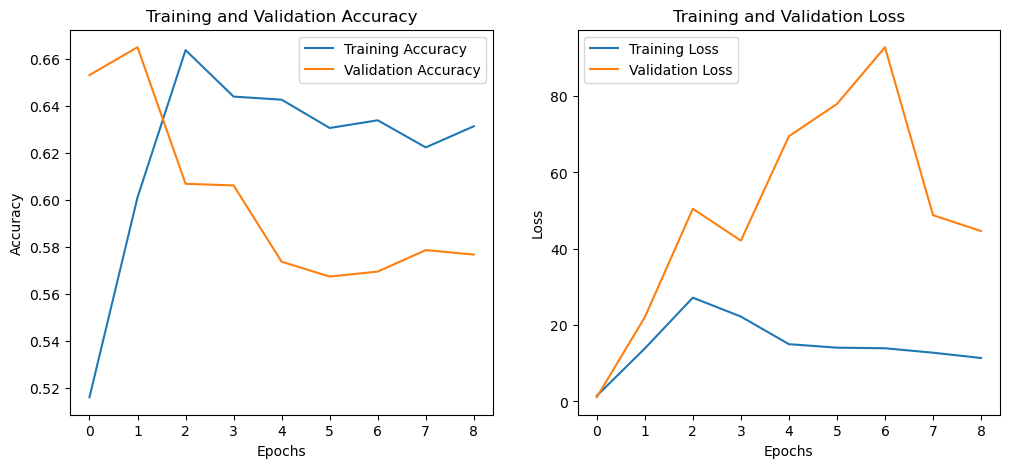

In [22]:
plot_history(h)

<a id="Testing-the-model"></a>
### Testing the model

Now, we'll load some test data to evaluate the model on data it has never seen before. This is important to make sure the model is not overfitting the training data, and that it can generalize to new data. Also, it will set a baseline for us to compare the model we'll fine-tune later.

In [23]:
# Test the model on the validation data
imgs_test = x_test
cols_test = test_df.drop("label", axis=1)
targets_test = test_df["label"]

pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)

round_pred = np.round(pred).astype(int)

results = round_pred == targets_test.values.reshape(-1,1)

print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")

19/46 [===========>..................] - ETA: 0s

2024-03-23 17:19:56.598698: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 0s 6ms/step
Test accuracy: 57.19%


As you can see, the accuracy is starting to rise, and it looks like the model already learned from the data with the hyperparameters we chose. But we can do better!

**However**, accuracy isn't the only metric we should look at. There're a lot more metrics that can be used to evaluate a model, and it's important to look at them all to get a better idea of how the model is performing. For example, the accuracy can be misleading if the dataset is imbalanced (which is the case here). If we have 99% of non-BTS objects, and 1% of BTS objects, a model that always predicts non-BTS will have an accuracy of 99%, but it's not a good model. This is why we'll look can look at the confusion matrix, the precision, the recall, and the F1 score.

**Here is are your first set of tasks:**

1. Using matplotlib or your favorite plotting library, plot the confusion matrix for the test set. Hint: You can use the [sklearn.metrics.confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to compute the confusion matrix, and the [sklearn.metrics.ConfusionMatrixDisplay](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html) to plot it.
2. Calculate the precision, recall, and F1 score for the test set. Hint: sklearn has some tools to help you with that :)
3. Nowadays, it's more common to also look at a Receiver Operating Characteristic (ROC) curve and AUC: https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc. Plot the ROC curve and compute the AUC for the test set.

For each of the plots and metrics you come up with, try your best to interpret the results. What do they mean? What do they tell you about the model? What can you conclude from them?

----


In [24]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

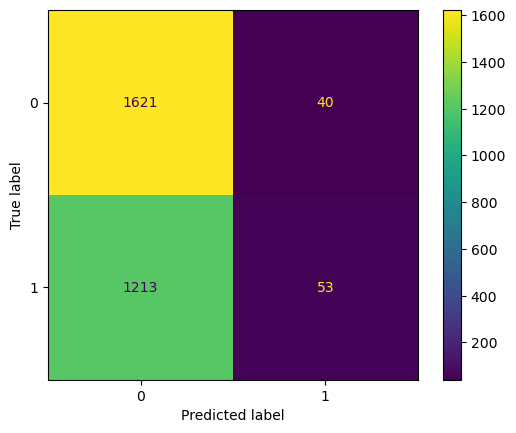

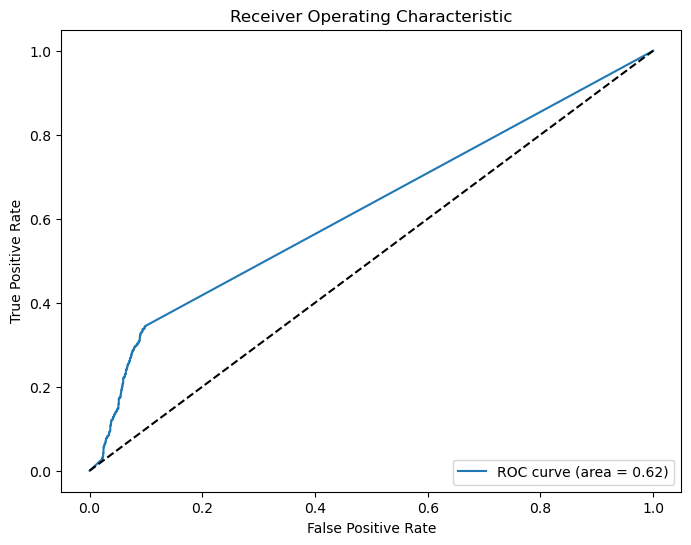

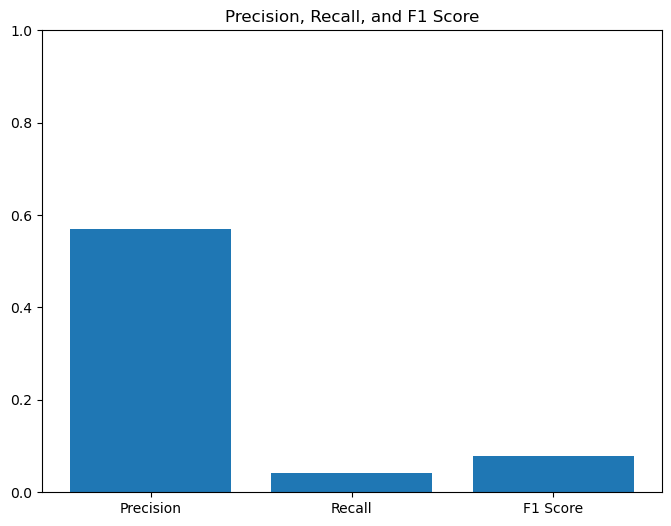

Precision: 0.5698924731182796
Recall: 0.04186413902053712
F1 Score: 0.07799852832965416
AUC: 0.6217944328251601


In [25]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, auc
import matplotlib.pyplot as plt

def plot_metric(targets_test, round_pred, pred):
    # Compute the confusion matrix
    cm = confusion_matrix(targets_test, round_pred)

    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()

    # Calculate precision, recall, and F1 score
    precision = precision_score(targets_test, round_pred)
    recall = recall_score(targets_test, round_pred)
    f1 = f1_score(targets_test, round_pred)

    # Compute ROC curve and AUC
    fpr, tpr, thresholds = roc_curve(targets_test, pred)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

    # Plot precision, recall, and F1 score
    plt.figure(figsize=(8, 6))
    x = ['Precision', 'Recall', 'F1 Score']
    y = [precision, recall, f1]
    plt.bar(x, y)
    plt.ylim([0.0, 1.0])
    plt.title('Precision, Recall, and F1 Score')
    plt.show()

    # Print the metrics
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("AUC:", roc_auc)

plot_metric(targets_test, round_pred, pred)

## Optimization: Grid search using Weights and Biases Sweeps

After looking at our basic model's result, we can easily imagine how it can be improved. One way to do that is to try different values for all of the hyperparemeters it uses, hoping to fine-tune their value to get the best result our of our existing model. This is called hyperparameter optimization, and it's a very common practice in machine learning. A great tool to do this automatically is a grid search, which will try all the possible combinations of hyperparameters you want to try, and return the best one. However, this can be very time consuming, and it's not always possible to try all the possible combinations. This is where Weights and Biases Sweeps comes in handy.

Let's use wandb.ai to fine-tune the model with their *sweeps* feature, which works pretty much like a grid search, but smarter. We'll use Weights and Biases Sweeps to perform a grid search over the hyperparameters of the model, such as: learning rate, batch size, dropout rate, etc.

First, we need to put all of the logic above in a function that we can call from the sweep configuration file.

----

##### We'd like you to try and beat the best score we've got so far! 

Here's what you can do, in order of difficulty (from easiest to hardest):
1. Create a new clean sweep on wandb.ai, with the configuration of your choice, adding, modifying, or removing hyperparameters as you wish. You might want to increase the worker count to cover more of the parameter space.

2. Try different loss functions and optimizers, and improve on how the initial weights are initialized.

3. Perform data augmentation on the cutouts, and use the augmented data to train the model. You can use the tf.keras.preprocessing.image.ImageDataGenerator (which you'll find in the code above already) to do this. You could also do the same for the metadata, but it's a little more complicated.

4. Play with the model's architecture. You can add, remove, or modify the layers as you wish. You could also try to use a different CNN architecture, such as ResNet, EfficientNet, etc.

5. Change the features used in the metadata model. You can add, remove, or modify the features used. You could also compute new features from the existing ones.

6. Improve time needed for inference. You can try to reduce the number of parameters in the model, or use a more efficient CNN architecture to make it more efficient. This is *key* for the model to be used in production, as we expect it to run on thousands of alerts every day.

7. Be creative! There are an infinite number of ways to improve a model, and we're sure you can come up with something we haven't thought of :)

**Once you have a model you are happy with, you should use the code you wrote in the [Testing the model](#Testing-the-model) section to evaluate it on the test set, and plot some of the metrics.**

----

# Model Research and Inspiration
For this model, we can also look elsewhere for other architectures, e.g. https://iopscience.iop.org/article/10.3847/1538-3881/abe853/pdf.

Replacing Conv2D with SeparableConv2D reduces the parameters and improves computational efficiency while maintaining feature extraction capability. Using GlobalAveragePooling2D instead of Flatten helps reduce overfitting by preserving the essential spatial information of the extracted features.

In [26]:
def BTSModelSep(config):
    # based on the config passed, generate the model
    # first we prepare the input layers
    triplet_input = Input(shape=(63, 63, 3), name='triplet')
    meta_input = Input(shape=(14,), name='metadata')

    # Conv branch
    x = layers.SeparableConv2D(16, (3, 3), activation='relu', padding="same")(triplet_input)
    x = layers.SeparableConv2D(16, (3, 3), activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(config["dropout_1"])(x)

    x = layers.SeparableConv2D(32, (3, 3), activation='relu', padding="same")(x)
    x = layers.SeparableConv2D(32, (3, 3), activation='relu', padding="same")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Dropout(config["dropout_2"])(x)

    x = layers.GlobalAveragePooling2D()(x)

    # Metadata branch
    y = layers.Dense(64, activation='relu')(meta_input)
    y = layers.Dropout(config["dropout_3"])(y)
    y = layers.Dense(32, activation='relu')(y)

    # Concatenate the two branches
    combined = layers.Concatenate()([x, y])
    x = layers.Dense(32, activation='relu')(combined)
    x = layers.Dropout(config["dropout_3"])(x)
    output = layers.Dense(1, activation='sigmoid')(x)

    model = Model(inputs=[triplet_input, meta_input], outputs=output)

    return model

In [27]:
model = BTSModelSep(config)
model.summary()
model.compile(optimizer=optimizer, loss=config['loss'], metrics=['accuracy'])


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 triplet (InputLayer)           [(None, 63, 63, 3)]  0           []                               
                                                                                                  
 separable_conv2d (SeparableCon  (None, 63, 63, 16)  91          ['triplet[0][0]']                
 v2D)                                                                                             
                                                                                                  
 separable_conv2d_1 (SeparableC  (None, 63, 63, 16)  416         ['separable_conv2d[0][0]']       
 onv2D)                                                                                           
                                                                                              

In [29]:
h = model.fit(
    training_generator,
    steps_per_epoch=0.8*len(x_train) // config["batch_size"],
    validation_data=validation_generator,
    validation_steps=(0.8*len(x_val)) // config["batch_size"],
    epochs=30,
    class_weight=class_weight,
    verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
)

Epoch 1/30


2024-03-23 17:20:36.112893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 17:20:36.567308: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


128/129 [============================>.] - ETA: 0s - loss: 10.5796 - accuracy: 0.4889

2024-03-23 17:20:42.179631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 17:20:42.241541: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 10s 65ms/step - loss: 10.5820 - accuracy: 0.4894 - val_loss: 5.4976 - val_accuracy: 0.5586 - lr: 1.5000e-04
Epoch 2/30
129/129 [==============================] - 8s 60ms/step - loss: 7.6620 - accuracy: 0.5006 - val_loss: 4.1801 - val_accuracy: 0.5498 - lr: 1.5000e-04
Epoch 3/30
129/129 [==============================] - 8s 59ms/step - loss: 6.5546 - accuracy: 0.5030 - val_loss: 4.4754 - val_accuracy: 0.5533 - lr: 1.5000e-04
Epoch 4/30
129/129 [==============================] - 8s 61ms/step - loss: 6.0584 - accuracy: 0.5065 - val_loss: 4.1918 - val_accuracy: 0.5643 - lr: 1.5000e-04
Epoch 5/30
129/129 [==============================] - 8s 64ms/step - loss: 5.8402 - accuracy: 0.5018 - val_loss: 3.1515 - val_accuracy: 0.5535 - lr: 1.5000e-04
Epoch 6/30
129/129 [==============================] - 8s 61ms/step - loss: 5.2965 - accuracy: 0.5079 - val_loss: 4.1763 - val_accuracy: 0.5604 - lr: 1.5000e-04
Epoch 7/30
129/129 [=============================

In [30]:
# Test the model on the validation data
imgs_test = x_test
cols_test = test_df.drop("label", axis=1)
targets_test = test_df["label"]

pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)

round_pred = np.round(pred).astype(int)

results = round_pred == targets_test.values.reshape(-1,1)

print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")

19/46 [===========>..................] - ETA: 0s

2024-03-23 17:23:49.841147: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 0s 7ms/step
Test accuracy: 54.70%


# Exploring a ResNet-Inspired Model Architecture

In [37]:
def resnet_block(x, filters, kernel_size, config):
    y = layers.Conv2D(filters, kernel_size, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = layers.ReLU()(y)
    y = layers.Dropout(config["dropout_1"])(y)

    y = layers.Conv2D(filters, kernel_size, padding='same')(y)
    y = layers.BatchNormalization()(y)

    out = layers.Add()([x, y])
    out = layers.ReLU()(out)
    return out

def BTS_ResNet(config):
    triplet_input = Input(shape=(63, 63, 3), name='triplet')
    meta_input = Input(shape=(14,), name='metadata')

    # Conv branch
    x = layers.Conv2D(16, (3, 3), padding='same')(triplet_input)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = resnet_block(x, 16, (3, 3), config)
    x = layers.Conv2D(32, (3, 3), padding='same')(triplet_input)
    x = layers.Dropout(config["dropout_2"])(x)
    x = resnet_block(x, 32, (3, 3), config)
    x = layers.GlobalAveragePooling2D()(x)

    # Metadata input branch
    y = layers.Dense(64, activation='relu')(meta_input)
    y = layers.Dropout(config["dropout_3"])(y)
    y = layers.Dense(32, activation='relu')(y)

    # Concatenate
    concatenated = layers.Concatenate()([x, y])
    concatenated = layers.Dense(32, activation='relu')(concatenated)
    concatenated = layers.Dropout(config["dropout_4"])(concatenated)

    # Output layer
    outputs = layers.Dense(1, activation='sigmoid')(concatenated)
    model = Model(inputs=[triplet_input, meta_input], outputs=outputs)
    
    return model

In [38]:
config.update({"dropout_4": 0.25})

model = BTS_ResNet(config)
model.summary()

model.compile(optimizer=optimizer, loss=config['loss'], metrics=['accuracy'])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 triplet (InputLayer)           [(None, 63, 63, 3)]  0           []                               
                                                                                                  
 conv2d_21 (Conv2D)             (None, 63, 63, 32)   896         ['triplet[0][0]']                
                                                                                                  
 dropout_19 (Dropout)           (None, 63, 63, 32)   0           ['conv2d_21[0][0]']              
                                                                                                  
 conv2d_22 (Conv2D)             (None, 63, 63, 32)   9248        ['dropout_19[0][0]']             
                                                                                            

In [39]:
h = model.fit(
    training_generator,
    steps_per_epoch=0.8*len(x_train) // config["batch_size"],
    validation_data=validation_generator,
    validation_steps=(0.8*len(x_val)) // config["batch_size"],
    epochs=30,
    class_weight=class_weight,
    verbose=1, callbacks=[early_stopping, LR_plateau, WandBLogger]
)

Epoch 1/30


2024-03-23 17:25:02.130899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 17:25:02.522669: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - ETA: 0s - loss: 13.8174 - accuracy: 0.5157

2024-03-23 17:25:09.138315: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-03-23 17:25:09.198788: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


129/129 [==============================] - 11s 77ms/step - loss: 13.8174 - accuracy: 0.5157 - val_loss: 5.4835 - val_accuracy: 0.5609 - lr: 4.5000e-05
Epoch 2/30
129/129 [==============================] - 9s 69ms/step - loss: 12.1931 - accuracy: 0.5001 - val_loss: 3.7746 - val_accuracy: 0.5780 - lr: 4.5000e-05
Epoch 3/30
129/129 [==============================] - 9s 70ms/step - loss: 11.5092 - accuracy: 0.5041 - val_loss: 3.2569 - val_accuracy: 0.5448 - lr: 4.5000e-05
Epoch 4/30
129/129 [==============================] - 9s 69ms/step - loss: 10.4777 - accuracy: 0.5077 - val_loss: 2.6450 - val_accuracy: 0.5580 - lr: 4.5000e-05
Epoch 5/30
129/129 [==============================] - 9s 70ms/step - loss: 10.0125 - accuracy: 0.5110 - val_loss: 2.1270 - val_accuracy: 0.5908 - lr: 4.5000e-05
Epoch 6/30
129/129 [==============================] - 9s 70ms/step - loss: 9.4665 - accuracy: 0.5127 - val_loss: 1.8901 - val_accuracy: 0.6020 - lr: 4.5000e-05
Epoch 7/30
129/129 [=========================

In [40]:
# Test the model on the validation data
imgs_test = x_test
cols_test = test_df.drop("label", axis=1)
targets_test = test_df["label"]

pred = model.predict([x_test, cols_test], batch_size=config['batch_size'], verbose=1)

round_pred = np.round(pred).astype(int)

results = round_pred == targets_test.values.reshape(-1,1)

print(f"Test accuracy: {100*np.sum(results) / len(results):.2f}%")

13/46 [=======>......................] - ETA: 0s

2024-03-23 17:28:28.732806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


46/46 [==============================] - 1s 10ms/step
Test accuracy: 61.77%
